### Imports

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize

from sklearn.model_selection import train_test_split
import tensorflow as tf

from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle

random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

Using TensorFlow backend.


Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [2]:
tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [3]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


### Load Data

In [4]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()
train_df = data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


### Missing values

In [6]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,39.268707
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,39.268707
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,39.268707
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,39.268707
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,39.268707


### Transform for NN

In [7]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

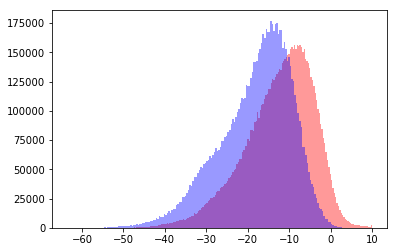

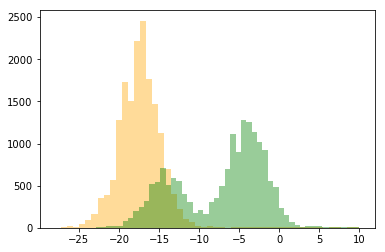

In [8]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

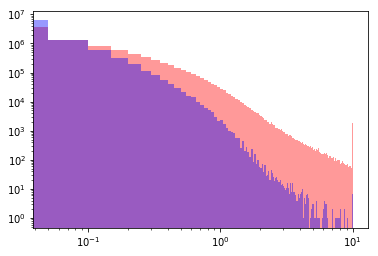

In [9]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

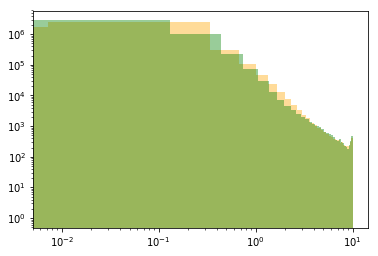

In [10]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [11]:
print(X.max())
print(X.min())
print(X.std())

10.0
-63.464207
9.98626650294


In [12]:
# pre-processing: divide by max and substract mean

#scale = np.max(X_train)
#X_train /= scale

#mean = np.mean(X_train)
#X_train -= mean

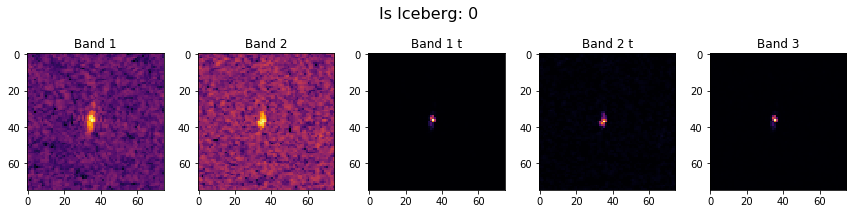

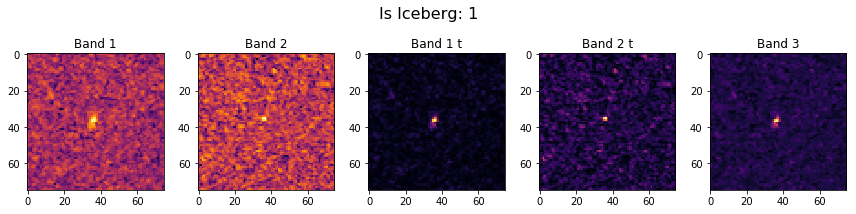

In [13]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [14]:
# = to_categorical(train_df.loc[:,'is_iceberg'], num_classes=2)
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
#y_angle['band_3'] = pd.Series(band_3.tolist()).apply(np.array)

### Split into train test and validation sets

In [15]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.3, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1122, 75, 75, 4)
(482, 75, 75, 4)


### Data augmentation

In [16]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3],temp_band_3),axis=3)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)                         
        return [temp_stacked1, temp_stacked2, temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)

#flow = datagen.flow(X_train, y_train)
#temp = flow.next()

(1122, 75, 75, 4)


### Wavelet denoising

In [17]:
def wavelet_denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(denoise_wavelet(image, convert2ycbcr=True))
    return np.stack(img_list,axis=2)

In [18]:
base_images = X_train_sample
wd_list = []
for i in range(base_images.shape[0]):
    wd_list.append(wavelet_denoising(X_train_sample[i]))
denoised_images = np.stack(wd_list,axis=0)
del(wd_list)
wd_list = []
for i in range(X_val.shape[0]):
    wd_list.append(wavelet_denoising(X_val[i]))
denoised_images_val = np.stack(wd_list,axis=0)

D:\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda3\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Anaconda3\envs\tf-gpu\lib\site-packages\pywt\_thresholding.py:25: RuntimeWarning: invalid value encountered in less
  cond = np.less(magnitude, value)


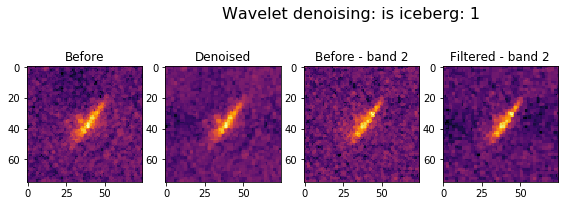

In [19]:
index=7
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Wavelet denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("Denoised")
ax2.imshow(denoised_images[index][:,:,0], cmap=cmap)
ax1 = fig.add_subplot(253)
ax1.set_title("Before - band 2")
ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax2 = fig.add_subplot(254)
ax2.set_title("Filtered - band 2")
ax2.imshow(denoised_images[index][:,:,1], cmap=cmap)
plt.show()

### NN denoising

In [20]:
#custom generator for denoising
from collections import Generator
class Datagen_denoising(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3]),axis=3)
        return temp_stacked, temp_stacked
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
        
datagen_denoising = Datagen_denoising(imagegen=datagen)
datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [21]:
m_input = Input(shape=(75,75,4), name='m_input')

#conv layers for main_input
x1 = BatchNormalization()(m_input)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
model_denoise = Model(inputs=[m_input,], outputs=[m_output])

model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])

In [22]:
model_denoise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_input (InputLayer)         (None, 75, 75, 4)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 4)         16        
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 77, 77, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 8)         296       
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 8)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 77, 77, 8)         0         
__________

In [23]:
#model training
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
                    steps_per_epoch=len(X)/8,
                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
                    validation_steps=len(X)/8,
                    #validation_data=[X_val,y_val],
                    epochs=10)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Epoch 1/10
201/200 [==============================] - 7s - loss: 18.7332 - mean_absolute_error: 2.3995 - val_loss: 15.0002 - val_mean_absolute_error: 2.2473
Epoch 2/10
201/200 [==============================] - 4s - loss: 11.7694 - mean_absolute_error: 1.9152 - val_loss: 12.7566 - val_mean_absolute_error: 2.0017
Epoch 3/10
201/200 [==============================] - 4s - loss: 12.4061 - mean_absolute_error: 1.9277 - val_loss: 11.5476 - val_mean_absolute_error: 1.9909
Epoch 4/10
201/200 [==============================] - 4s - loss: 11.6051 - mean_absolute_error: 1.9195 - val_loss: 4.5012 - val_mean_absolute_error: 1.2960
Epoch 5/10
201/200 [==============================] - 4s - loss: 9.1998 - mean_absolute_error: 1.7411 - val_loss: 9.6489 - val_mean_absolute_error: 1.7491
Epoch 6/10
201/200 [==============================] - 4s - loss: 9.3130 - mean_absolute_error: 1.7246 - val_loss: 5.4778 - val_mean_absolute_error: 1.3571
Epoch 7/10
201/200 [==============================] - 4s - loss

In [24]:
new_images = model_denoise.predict(X_train_sample, verbose=1)
new_images_val = model_denoise.predict(X_val, verbose=1)

480/482 [============================>.] - ETA: 0s

In [25]:
new_images.shape

(1122, 75, 75, 4)

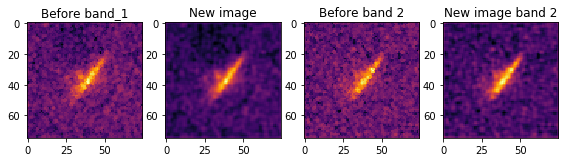

In [26]:
index=7
cmap="inferno"
fig = plt.figure(figsize=(12,6))
#fig.suptitle("Image filtering: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before band_1")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("New image")
ax2.imshow(new_images[index][:,:,0], cmap=cmap)
ax3 = fig.add_subplot(253)
ax3.set_title("Before band 2")
ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax4 = fig.add_subplot(254)
ax4.set_title("New image band 2")
ax4.imshow(new_images[index][:,:,1], cmap=cmap)
plt.show()

### Filtering regional maxima

In [27]:
def img_filtering(img):
    img_list = []
    for i in range(4):
        image = img[:,:,i]
        h = (image.max() - image.min()) * 0.5
        seed = image - h
        dilated = reconstruction(seed, image, method='dilation')
        hdome = image - dilated
        img_list.append(hdome)
    return np.stack(img_list,axis=2)

In [28]:
base_images = new_images
base_images_val = new_images_val
f_list = []
for i in range(base_images.shape[0]):
    f_list.append(img_filtering(base_images[i]))
filtered_images = np.stack(f_list,axis=0)
f1_list=[]
for i in range(base_images_val.shape[0]):
    f1_list.append(img_filtering(base_images_val[i]))
filtered_images_val = np.stack(f1_list,axis=0)

In [29]:
filtered_images.shape

(1122, 75, 75, 4)

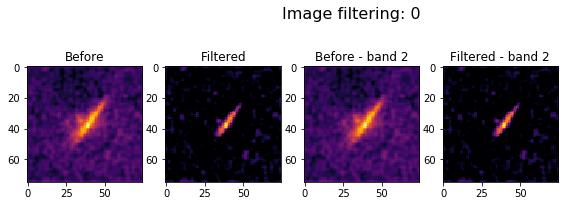

In [30]:
index=7
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Image filtering: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before")
ax1.imshow(base_images[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("Filtered")
ax2.imshow(filtered_images[index][:,:,0], cmap=cmap)
ax1 = fig.add_subplot(253)
ax1.set_title("Before - band 2")
ax1.imshow(base_images[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(254)
ax2.set_title("Filtered - band 2")
ax2.imshow(filtered_images[index][:,:,0], cmap=cmap)
plt.show()

### Keras model

In [31]:
model_code="CNN_2017_12_19_v15"
model_comment="2 CNN inputs 3,3 conv filters - wavelet denoising"

In [32]:
%%writefile current_model.py

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')

#conv layers for main_input
x1 = BatchNormalization()(main_input)
x1 = Conv2D(64, (3,3), activation='relu')(x1)
x1 = MaxPooling2D((2, 2), strides=(2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

#conv layers for aux_input
x2 = BatchNormalization()(aux_input)
x2 = Conv2D(64, (3,3), activation='relu')(x2)
x2 = MaxPooling2D((2, 2), strides=(2, 2))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.2)(x2)

x = Concatenate(axis=3)([x1,x2])
    
#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
merged = Concatenate()([x, angle_input])

#dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input,angle_input], outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Overwriting current_model.py


In [33]:
%run -i current_model.py

In [34]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

def step_decay2(epoch):
    initial_lrate = 0.000001
    drop = 0.66
    patience = 7.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
    if math.fmod(epoch, patience) == 0:
        print("Setting learning rate: ",lrate)
    return lrate

# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001):
        self.initial_lrate=initial_lrate

    def step_decay(epoch,logs):
        initial_lrate = self.initial_lrate
        drop = 0.66
        patience = 7.0
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

def get_callbacks(filepath, patience=10, step_decay=step_decay):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    lrScheduler = LearningRateScheduler(step_decay)
    return [msave, lrScheduler]

In [35]:
model_f.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 75, 75, 2)     0                                            
____________________________________________________________________________________________________
aux_input (InputLayer)           (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_4 (BatchNorm (None, 75, 75, 2)     8           main_input[0][0]                 
____________________________________________________________________________________________________
batch_normalization_6 (BatchNorm (None, 75, 75, 3)     12          aux_input[0][0]                  
___________________________________________________________________________________________

### Model Training

In [36]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay)

In [37]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(denoised_images, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(denoised_images_val, y_val, batch_size=24, shuffle=False), 
                    validation_steps=len(X_val)/12,
                    #validation_data=[X_val,y_val],
                    epochs=56, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  0.001
Epoch 1/56
47/46 [==============================] - 14s - loss: 0.6875 - acc: 0.6776 - val_loss: 1.2373 - val_acc: 0.4813
Epoch 2/56
47/46 [==============================] - 12s - loss: 0.5981 - acc: 0.7222 - val_loss: 0.6969 - val_acc: 0.5191
Epoch 3/56
47/46 [==============================] - 12s - loss: 0.4902 - acc: 0.7657 - val_loss: 1.0431 - val_acc: 0.4787
Epoch 4/56
47/46 [==============================] - 12s - loss: 0.4690 - acc: 0.7914 - val_loss: 1.0429 - val_acc: 0.4819
Epoch 5/56
47/46 [==============================] - 12s - loss: 0.4283 - acc: 0.7961 - val_loss: 0.6892 - val_acc: 0.4862
Epoch 6/56
47/46 [==============================] - 12s - loss: 0.4108 - acc: 0.8121 - val_loss: 1.9052 - val_acc: 0.4787
Epoch 7/56
47/46 [==============================] - 12s - loss: 0.3714 - acc: 0.8437 - val_loss: 1.2180 - val_acc: 0.4745
Setting learning rate:  0.00066
Epoch 8/56
47/46 [==============================] - 12s - loss: 0.3644 - acc: 0.8378

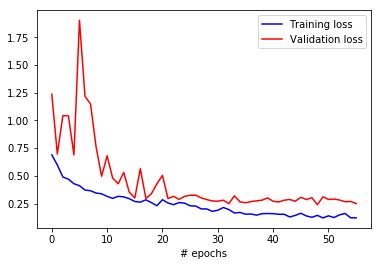

In [38]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [39]:
#addtional training epochs
callbacks = get_callbacks(filepath=model_best_weights_path, patience=10, step_decay=step_decay2)
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(denoised_images, y_train_sample, batch_size=24),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(denoised_images_val, y_val, batch_size=32, shuffle=False), 
                    validation_steps=len(X_val)/12,
                    #validation_data=[X_val,y_val],
                    epochs=14, callbacks=callbacks)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

Setting learning rate:  1e-06
Epoch 1/14
47/46 [==============================] - 15s - loss: 0.1167 - acc: 0.9548 - val_loss: 0.2606 - val_acc: 0.8970
Epoch 2/14
47/46 [==============================] - 14s - loss: 0.1235 - acc: 0.9521 - val_loss: 0.2626 - val_acc: 0.8970
Epoch 3/14
47/46 [==============================] - 14s - loss: 0.1048 - acc: 0.9607 - val_loss: 0.2697 - val_acc: 0.9018
Epoch 4/14
47/46 [==============================] - 14s - loss: 0.1028 - acc: 0.9672 - val_loss: 0.2685 - val_acc: 0.9018
Epoch 5/14
47/46 [==============================] - 14s - loss: 0.1334 - acc: 0.9468 - val_loss: 0.2626 - val_acc: 0.9034
Epoch 6/14
47/46 [==============================] - 14s - loss: 0.1091 - acc: 0.9560 - val_loss: 0.2564 - val_acc: 0.9043
Epoch 7/14
47/46 [==============================] - 14s - loss: 0.1386 - acc: 0.9477 - val_loss: 0.2656 - val_acc: 0.8970
Setting learning rate:  6.6e-07
Epoch 8/14
47/46 [==============================] - 14s - loss: 0.1165 - acc: 0.9592

In [40]:
for key in H.history:
    H.history[key].extend(H2.history[key])

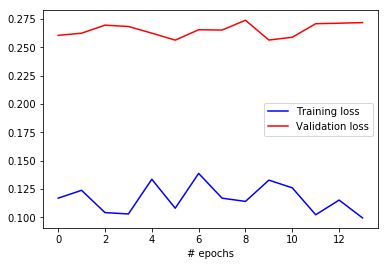

In [41]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

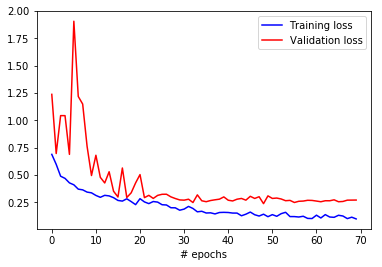

In [42]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [43]:
model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
model_f.save(model_object_path)
#model_f = load_model(model_object_path)

### Saving model history

In [44]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
with open('current_model.py','r') as model_python_code_file:
    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
                                    "val_loss [min]":[H.history['val_loss'][argmin]],
                                    "epoch [val_loss [min]]":argmin,
                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
                                    
                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
                                    "epoch [val_acc [max]]":argmax_acc,
                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
                                    
                                    "model_path":[model_object_path],
                                    "model_weights_path":[model_best_weights_path],
                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
                                    "model_comment":[model_comment]
                                })
                               
models_history = models_history[["timestamp", 
                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
                                 "model_path","model_weights_path","model_python_code","model_comment"]]
models_history.head()

,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
0,2017_12_20_07_28_19,48,0.23898,0.142688,0.903192,0.951872,61,0.904255,0.108134,0.25644,0.956328,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\nmain_input = Input(shape=(75,75,2), name='ma...","2 CNN inputs 3,3 conv filters - wavelet denoising"


In [45]:
print("model comment:", model_comment)
print("Min validation loss epoch:")
print("epoch: %d" %(argmin),
      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
     )
print("Max validation accuracy epoch:")
print("epoch: %d" %(argmax_acc),
      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
     )


model comment: 2 CNN inputs 3,3 conv filters - wavelet denoising
Min validation loss epoch:
epoch: 48 ; val loss [min] 0.2390:  ; training loss: 0.1427 ; val acc: 0.9032 ; training acc: 0.9519 
Max validation accuracy epoch:
epoch: 61 ; val loss 0.2564:  ; training loss: 0.1081 ; val acc [max]: 0.9043 ; training acc: 0.9563 


In [46]:
with open('models_history.csv', 'a') as f:
    models_history.to_csv(f, header=False,index=False)
    #models_history.to_csv(f, index=False)

In [47]:
df = pd.read_csv('models_history.csv')
df.tail()

,timestamp,epoch [val_loss [min]],val_loss [min],training_loss [val_loss [min]],val_acc [val_loss [min]],training_acc [val_loss [min]],epoch [val_acc [max]],val_acc [max],training_loss [val_acc [max]],val_loss [val_acc [max]],training_acc [val_acc [max]],model_path,model_weights_path,model_python_code,model_comment
7,2017_12_20_02_35_59,48,0.181888,0.196434,0.932979,0.919786,59,0.939362,0.193095,0.185062,0.917112,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\nmain_input = Input(shape=(75,75,2), name='ma...",2 CNN inputs with 64 initial conv filters - th...
8,2017_12_20_02_58_27,49,0.179903,0.180516,0.918919,0.928699,45,0.937234,0.212429,0.182675,0.911765,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\nmain_input = Input(shape=(75,75,2), name='ma...","2 CNN inputs 5,5 conv filters"
9,2017_12_20_06_45_11,11,0.301921,0.296855,0.874468,0.877897,39,0.876596,0.156371,0.359703,0.940285,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\nmain_input = Input(shape=(75,75,2), name='ma...","2 CNN inputs 3,3 conv filters - wavelet denois..."
10,2017_12_20_07_09_27,17,0.278743,0.241129,0.898936,0.900178,17,0.898936,0.241129,0.278743,0.900178,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\nmain_input = Input(shape=(75,75,2), name='ma...","2 CNN inputs 3,3 conv filters - wavelet denois..."
11,2017_12_20_07_28_19,48,0.238980,0.142688,0.903192,0.951872,61,0.904255,0.108134,0.256440,0.956328,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,L:\Data Science\GIT\Statoil-C-CORE-Iceberg-Cla...,"\nmain_input = Input(shape=(75,75,2), name='ma...","2 CNN inputs 3,3 conv filters - wavelet denoising"


### Predictions

In [48]:
model_f.load_weights(model_best_weights_path)

In [49]:
model_f.evaluate(X_val,y_val, verbose=1, batch_size=64)

ValueError: The model expects 3 input arrays, but only received one array. Found: array with shape (482, 75, 75, 4)

In [ ]:
test_df = pd.read_json("Data/test/test.json")

In [ ]:
test_df.head()

In [ ]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)

In [ ]:
predictions = model.predict(X_test,verbose=1, batch_size=64)

In [ ]:
submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions.reshape(-1)})
submission.head()

In [ ]:
submission.to_csv("submission.v7.csv", index=False)